In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from ta import add_all_ta_features
from ta.utils import dropna
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

nasdaq_tickers = ['TMUSR', 'AAPL', 'MSFT', 'AMZN', 'FB', 'GOOGL', 'GOOG', 'INTC', 'NVDA', 'ADBE',
               'PYPL', 'CSCO', 'NFLX', 'PEP', 'TSLA', 'CMCSA', 'AMGN', 'COST', 'TMUS', 'AVGO',
               'TXN', 'CHTR', 'QCOM', 'GILD', 'SBUX', 'INTU', 'VRTX', 'MDLZ', 'ISRG', 'FISV',
               'BKNG', 'ADP', '', 'ATVI', 'AMD', 'JD', 'MU', 'AMAT', 'ILMN', 'ADSK',
               'CSX', 'MELI', 'LRCX', 'ADI', 'ZM', 'BIIB', 'EA', 'KHC', 'WBA', 'LULU',
               'EBAY', 'MNST', 'DXCM', 'EXC', 'BIDU', 'XEL', 'WDAY', 'DOCU', 'SPLK', 'ORLY',
               'NXPI', 'CTSH', 'KLAC', 'SNPS', 'SGEN', 'ASML', 'IDXX', 'CSGP', 'CTAS', 'VRSK',
               'MAR', 'CDNS', 'PAYX', 'ALXN', 'MCHP', 'SIRI', 'ANSS', 'VRSN', 'FAST', 'BMRN',
               'XLNX', 'INCY','DLTR', 'SWKS', 'ALGN', 'CERN', 'CPRT', 'CTXS', 'TTWO', 'MXIM',
               'CDW', 'CHKP', 'WDC', 'ULTA', 'NTAP', 'FOXA', 'LBTYK']

In [3]:
data = yf.Ticker(nasdaq_tickers[1]).history(period='5y').drop(columns=['Dividends','Stock Splits'])
data = add_all_ta_features(data, open="Open", high="High", low="Low", close="Close", volume="Volume").iloc[51:,:]
data.tail()

/Users/louisdelacour/opt/anaconda3/lib/python3.9/site-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/louisdelacour/opt/anaconda3/lib/python3.9/site-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


,Open,High,Low,Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2022-11-08 00:00:00-05:00,140.410004,141.429993,137.490005,139.500000,89908500,5.785392e+09,2797802300,0.023622,-3.637152e+07,8.983562,...,-1.238924,-0.723910,-0.515014,3.090972,2.860103,0.230869,147.562916,0.417508,0.416639,247.062113
2022-11-09 00:00:00-05:00,138.500000,138.550003,134.589996,134.869995,74917800,5.721068e+09,2722884500,0.020671,-8.072842e+07,-15.275965,...,-1.632795,-0.905687,-0.727108,0.926809,2.473444,-1.546635,146.508759,-3.319000,-3.375329,235.543122
2022-11-10 00:00:00-05:00,141.240005,146.869995,139.500000,146.869995,118854000,5.839922e+09,2841738500,0.031464,1.345539e+08,41.018815,...,-1.254009,-0.975351,-0.278658,2.863489,2.551453,0.312036,146.512012,8.897457,8.523649,265.397927
2022-11-11 00:00:00-05:00,145.820007,150.009995,144.369995,149.699997,93903800,5.923503e+09,2935642300,0.120056,1.532959e+08,24.054598,...,-0.786496,-0.937580,0.151084,2.283620,2.497886,-0.214266,146.590505,1.926875,1.908546,272.438690
2022-11-14 00:00:00-05:00,148.970001,150.279999,147.429993,148.279999,73308800,5.893923e+09,2862333500,0.076394,1.165253e+08,6.472978,...,-0.490993,-0.848263,0.357270,0.081092,2.014528,-1.933435,146.625227,-0.948563,-0.953090,268.905876


In [3]:
pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29088 sha256=fa88d227f7910d7d019cc2a8602bb2bf71a2cc665576e68497e7665cad44bbbb
  Stored in directory: /Users/louisdelacour/Library/Caches/pip/wheels/6a/76/03/7f785aaa50b9c6ec7e3fd105a62c1b2c45a034512d51e024a9
Successfully built ta
Note: you may need to restart the kernel to use updated packages.


Original P value: 0.8098594825490957
Differenced p value: 7.422686431556039e-20


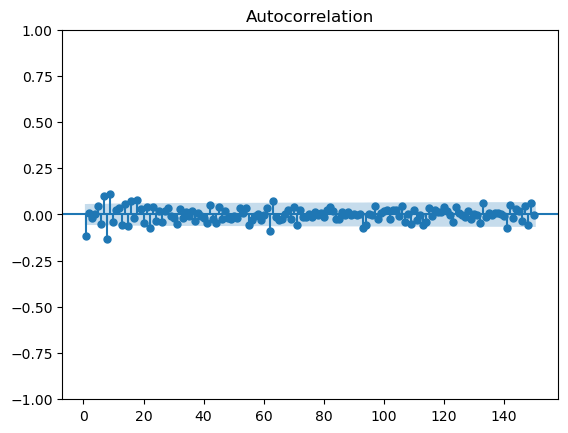

/Users/louisdelacour/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


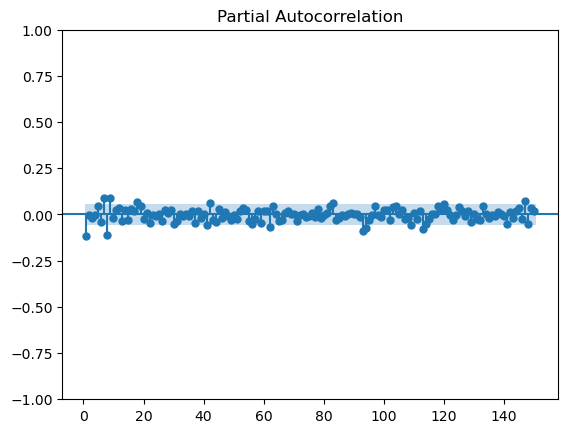

In [4]:
#stationnaire => pas de saisonnalité, aléatoire mais de moyenne constante, ne dépend pas du temps
#test de stationnarité : si la série est non stationnaire => elle possede une tendance et saisonnalité, et dépend du temps (p>0.05)

AdfResult1 = adfuller(data['Close'])
print ("Original P value:",AdfResult1[1]) 

#donc la série est non stationnaire et on doit la différencier pour utiiser arima
data['log_diff_data'] = np.log(data['Close'].values)
data['log_diff_data'] = data['log_diff_data'].diff(1)
AdfResult2 = adfuller(data['log_diff_data'].dropna())
print ("Differenced p value:",AdfResult2[1]) 

plot_acf(data['log_diff_data'].dropna(), lags=150,zero=False)
plt.show()

plot_pacf(data['log_diff_data'].dropna(), lags=150,zero=False)
plt.show()

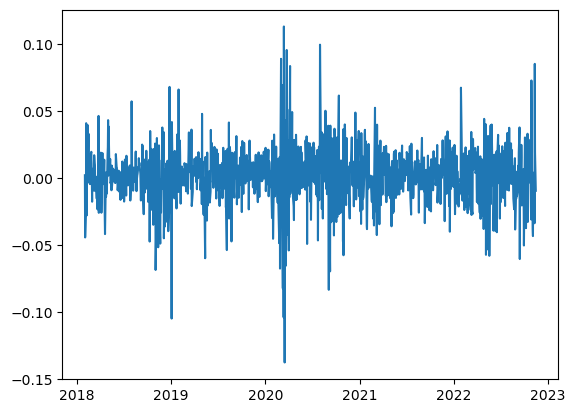

In [5]:
plt.plot(data['log_diff_data'])

In [6]:
res = sm.tsa.seasonal_decompose(data['Close'],freq=365)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

TypeError: seasonal_decompose() got an unexpected keyword argument 'freq'

In [7]:
corr_matrix = data.corr()
upperMatrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
corrFeatures = [column for column in upperMatrix.columns if any(upperMatrix[column] > 0.90)]
corrFeatures

/var/folders/p1/t6dp7fjx39v2j8bnc1tv9bq80000gn/T/ipykernel_13702/4268128535.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upperMatrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


['High',
 'Low',
 'Close',
 'volume_adi',
 'volume_obv',
 'volume_vwap',
 'volume_nvi',
 'volatility_bbm',
 'volatility_bbh',
 'volatility_bbl',
 'volatility_kcc',
 'volatility_kch',
 'volatility_kcl',
 'volatility_kcp',
 'volatility_dcl',
 'volatility_dch',
 'volatility_dcm',
 'volatility_dcw',
 'volatility_dcp',
 'trend_macd_signal',
 'trend_sma_fast',
 'trend_sma_slow',
 'trend_ema_fast',
 'trend_ema_slow',
 'trend_vortex_ind_diff',
 'trend_kst',
 'trend_kst_sig',
 'trend_ichimoku_conv',
 'trend_ichimoku_base',
 'trend_ichimoku_a',
 'trend_ichimoku_b',
 'trend_cci',
 'trend_visual_ichimoku_a',
 'trend_visual_ichimoku_b',
 'trend_aroon_ind',
 'trend_psar_up',
 'trend_psar_down',
 'momentum_rsi',
 'momentum_stoch_rsi_d',
 'momentum_tsi',
 'momentum_stoch',
 'momentum_stoch_signal',
 'momentum_wr',
 'momentum_ao',
 'momentum_ppo',
 'momentum_ppo_signal',
 'momentum_ppo_hist',
 'momentum_kama',
 'others_dlr',
 'others_cr',
 'log_diff_data']

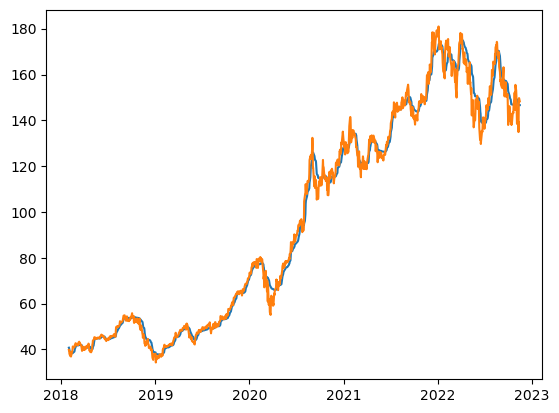

In [8]:
plt.plot(data['momentum_kama'])
plt.plot(data['Close'])

In [9]:
data.isna().sum().max()

716

In [10]:
len(data)

1207